In [72]:
import colorsys
import geopandas as gpd
import json
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import pandas as pd

from matplotlib.patches import Polygon
from matplotlib.patches import Circle
from shapely.ops import polygonize

In [73]:
# Constants
EDGE_COLOR = "gray"
GRID_COLOR = "#F1F1F1"
SUN_COLOR = "gold"
SUN_EDGE_COLOR = "orange"
# final_1.png
COLOR = "#503828"
ZONE_COLORS = {
    "Core Enchantment Zone": "#edc85b",
    "Stuart  Zone": "#f09c27",
    "Stuart Zone": "#f09c27",
    "Colchuck Zone": "#0e3789",
    "Snow Zone": "#62abb0",
    "Eightmile/Caroline Zone": "#c8d2a9",
}
COLORMAP = "Blues"
# final_2.png
COLOR = "#057943"
ZONE_COLORS = {
    "Core Enchantment Zone": "#edc85b",
    "Stuart  Zone": "#f09c27",
    "Stuart Zone": "#f09c27",
    "Colchuck Zone": "#62abb0",
    "Snow Zone": "#887056",
    "Eightmile/Caroline Zone": "#c8d2a9",
}
COLORMAP = "Greens"

TITLE_FS = 14
W = 10
H = 6

In [74]:
# Read in data
df = pd.read_csv("2022.csv")
df["entry_date"] = pd.to_datetime(df["entry_date"])
df["day_of_week"] = (df["entry_date"].dt.dayofweek + 1) % 7
df["week_of_year"] = df["entry_date"].dt.isocalendar().week
df["day_of_month"] = df["entry_date"].dt.day

df_hist = pd.read_csv("historical.csv")
df_zones = pd.read_csv("2022_by_zone.csv")

df_colors = (
    pd.DataFrame.from_dict(ZONE_COLORS, orient="index")
    .reset_index()
    .rename(columns={"index": "id", 0: "color"})
)
df_places = gpd.read_file("geojson/zones.geojson")
df_places = df_places.set_index("id").join(df_colors.set_index("id")).reset_index()

df_rivers = gpd.read_file("geojson/rivers.geojson")
df_trails = gpd.read_file("geojson/trails.geojson")

df_lakes = gpd.read_file("geojson/lakes.geojson")
df_lakes["geometry"] = gpd.GeoSeries(polygonize(df_lakes["geometry"]))

In [75]:
# Set up fonts
font_path = "fonts/Lato/Lato-Regular.ttf"
fm.fontManager.addfont(font_path)
fm.fontManager.addfont("fonts/Lato/Lato-Bold.ttf")
prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = prop.get_name()

TITLE_FONT = fm.FontProperties(
    fname="/home/agale/enchantments-lottery/fonts/Fredericka_the_Great/FrederickatheGreat-Regular.ttf"
)

In [76]:
def create_axes():
    plt.clf()
    fig = plt.figure(dpi=200, figsize=(W, H), facecolor="white")
    fig.patch.set_facecolor("white")

    # Past applications line chart
    ax1 = fig.add_axes([0, 0.8, 0.18, 0.16])
    # Group size bar chart
    ax2 = fig.add_axes([0, 0.52, 0.18, 0.16])
    # Applications by zone mountains
    ax3 = fig.add_axes([0, 0, 0.7, 0.6])
    # Map
    ax4 = fig.add_axes([0.2, 0.5, 0.48, 0.5])
    # Heatmap of applications
    ax5 = fig.add_axes([0.7, 0, 0.15, 0.8])
    # Applications by day of week
    ax6 = fig.add_axes([0.7, 0.85, 0.15, 0.15])
    # Applications by week of year
    ax7 = fig.add_axes([0.89, 0, 0.1, 0.8])

    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

    # Set defaults for axes
    for ax in axes:
        ax.xaxis.set_tick_params(which="both", length=0)
        ax.yaxis.set_tick_params(which="both", length=0)

        for spine in ax.spines.values():
            spine.set_edgecolor(EDGE_COLOR)
            spine.set_visible(False)

        ax.axis("off")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(which="both", axis="y", ls="--", color=GRID_COLOR, linewidth=1)
        ax.set_axisbelow(True)
    return axes


def number_format_axis(axis):
    """
    Set the provided axis to report shortened numbers in the thousands.
    """
    axis.set_major_formatter(
        ticker.FuncFormatter(
            lambda x, pos: "0" if x == 0 else "{:,.0f}".format(x / 1000) + "K"
        )
    )


def scale_lightness(name, scale_l):
    """
    Scale the provided color by the scale ratio.
    """
    color = matplotlib.colors.ColorConverter.to_rgb(name)
    h, l, s = colorsys.rgb_to_hls(*color)
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s=s)


def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

<Figure size 432x288 with 0 Axes>

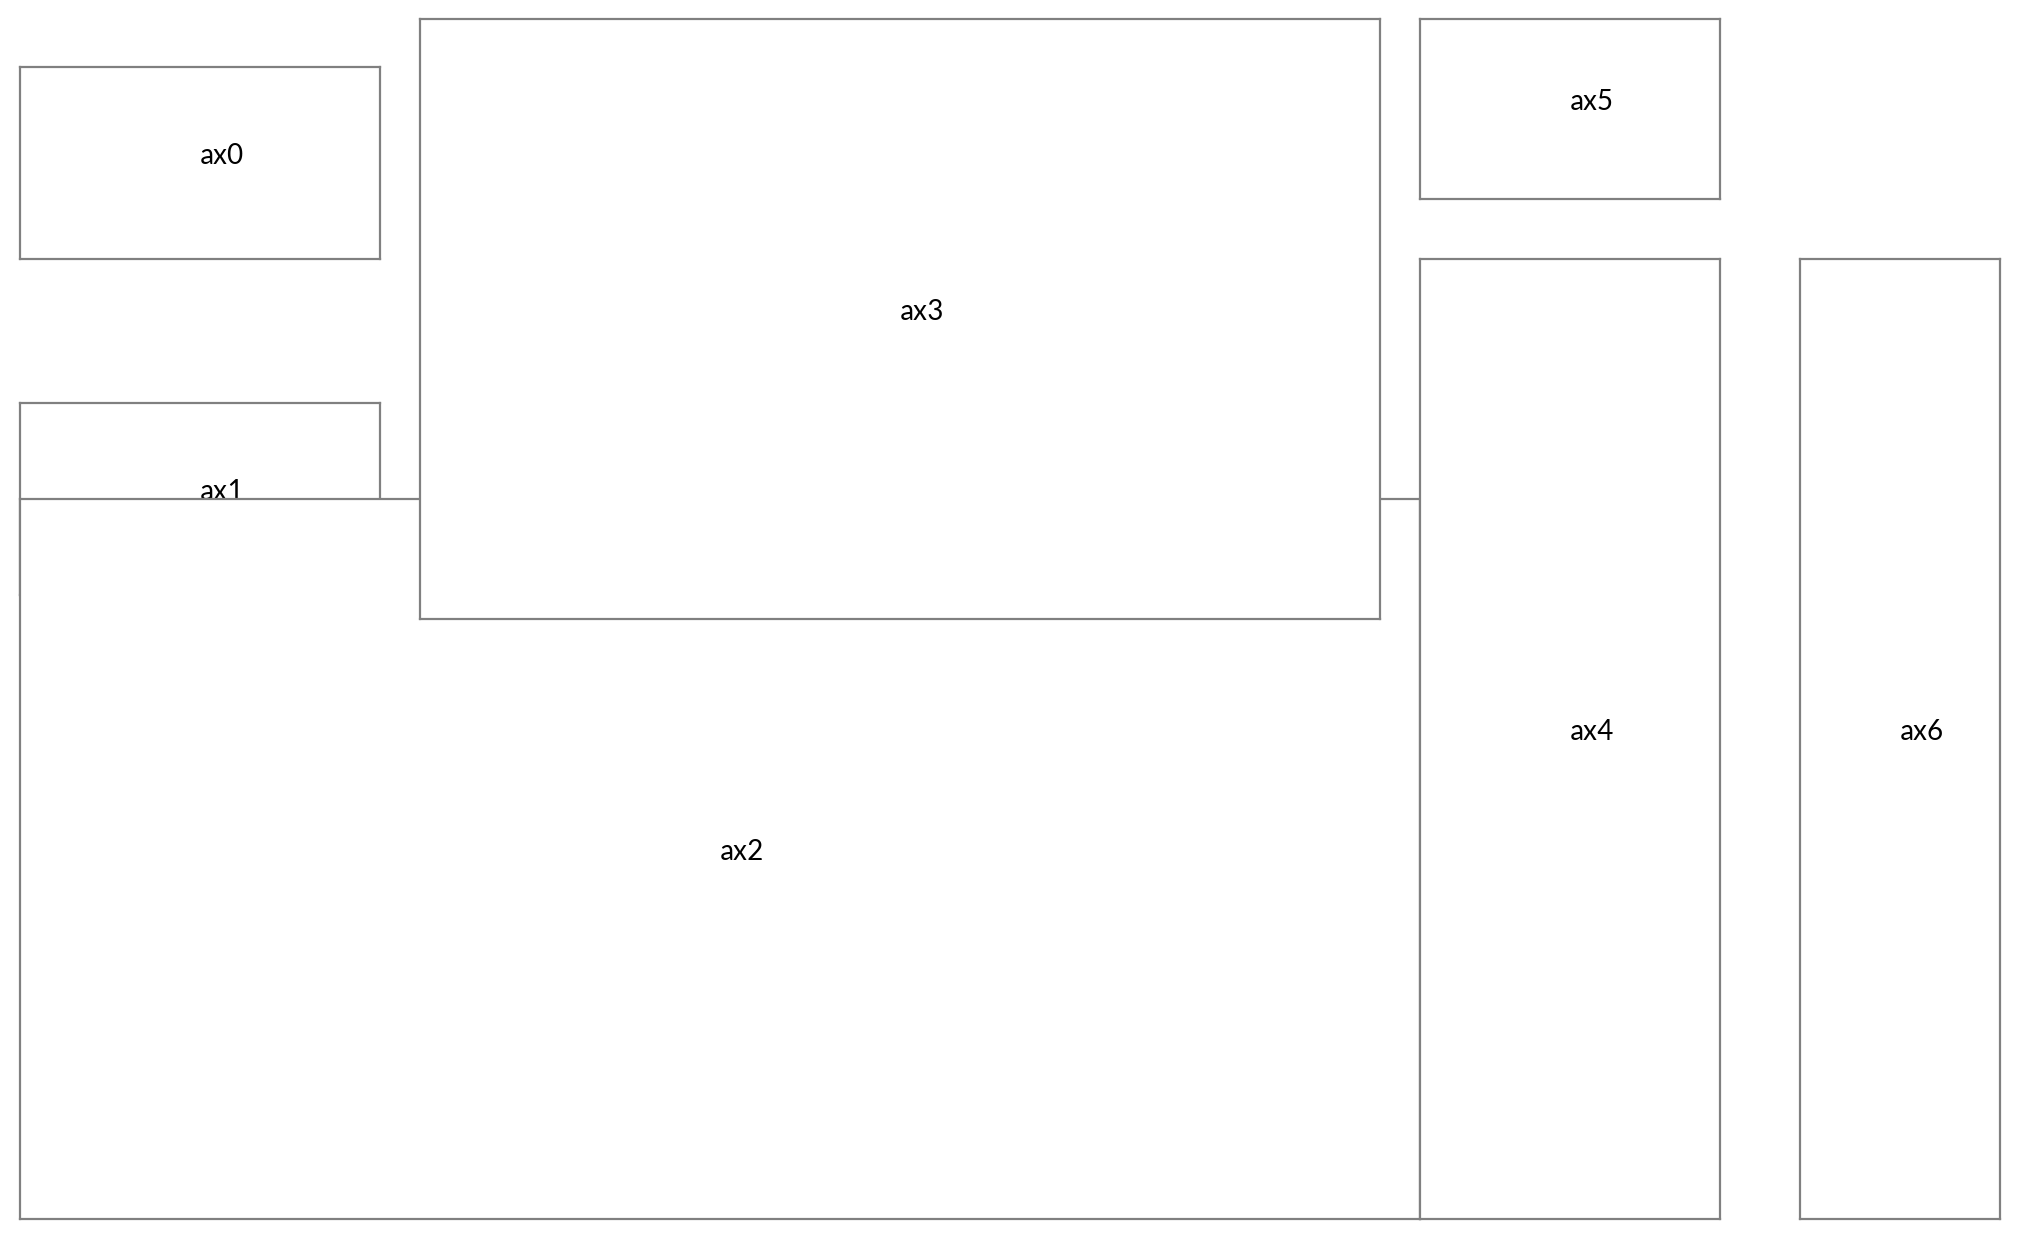

In [77]:
# Sample layout of axes
axes = create_axes()

for i, ax in enumerate(axes):
    ax.axis("on")
    for spine in ax.spines.values():
        spine.set_visible(True)
    ax.text(0.5, 0.5, "ax" + str(i))

<Figure size 432x288 with 0 Axes>

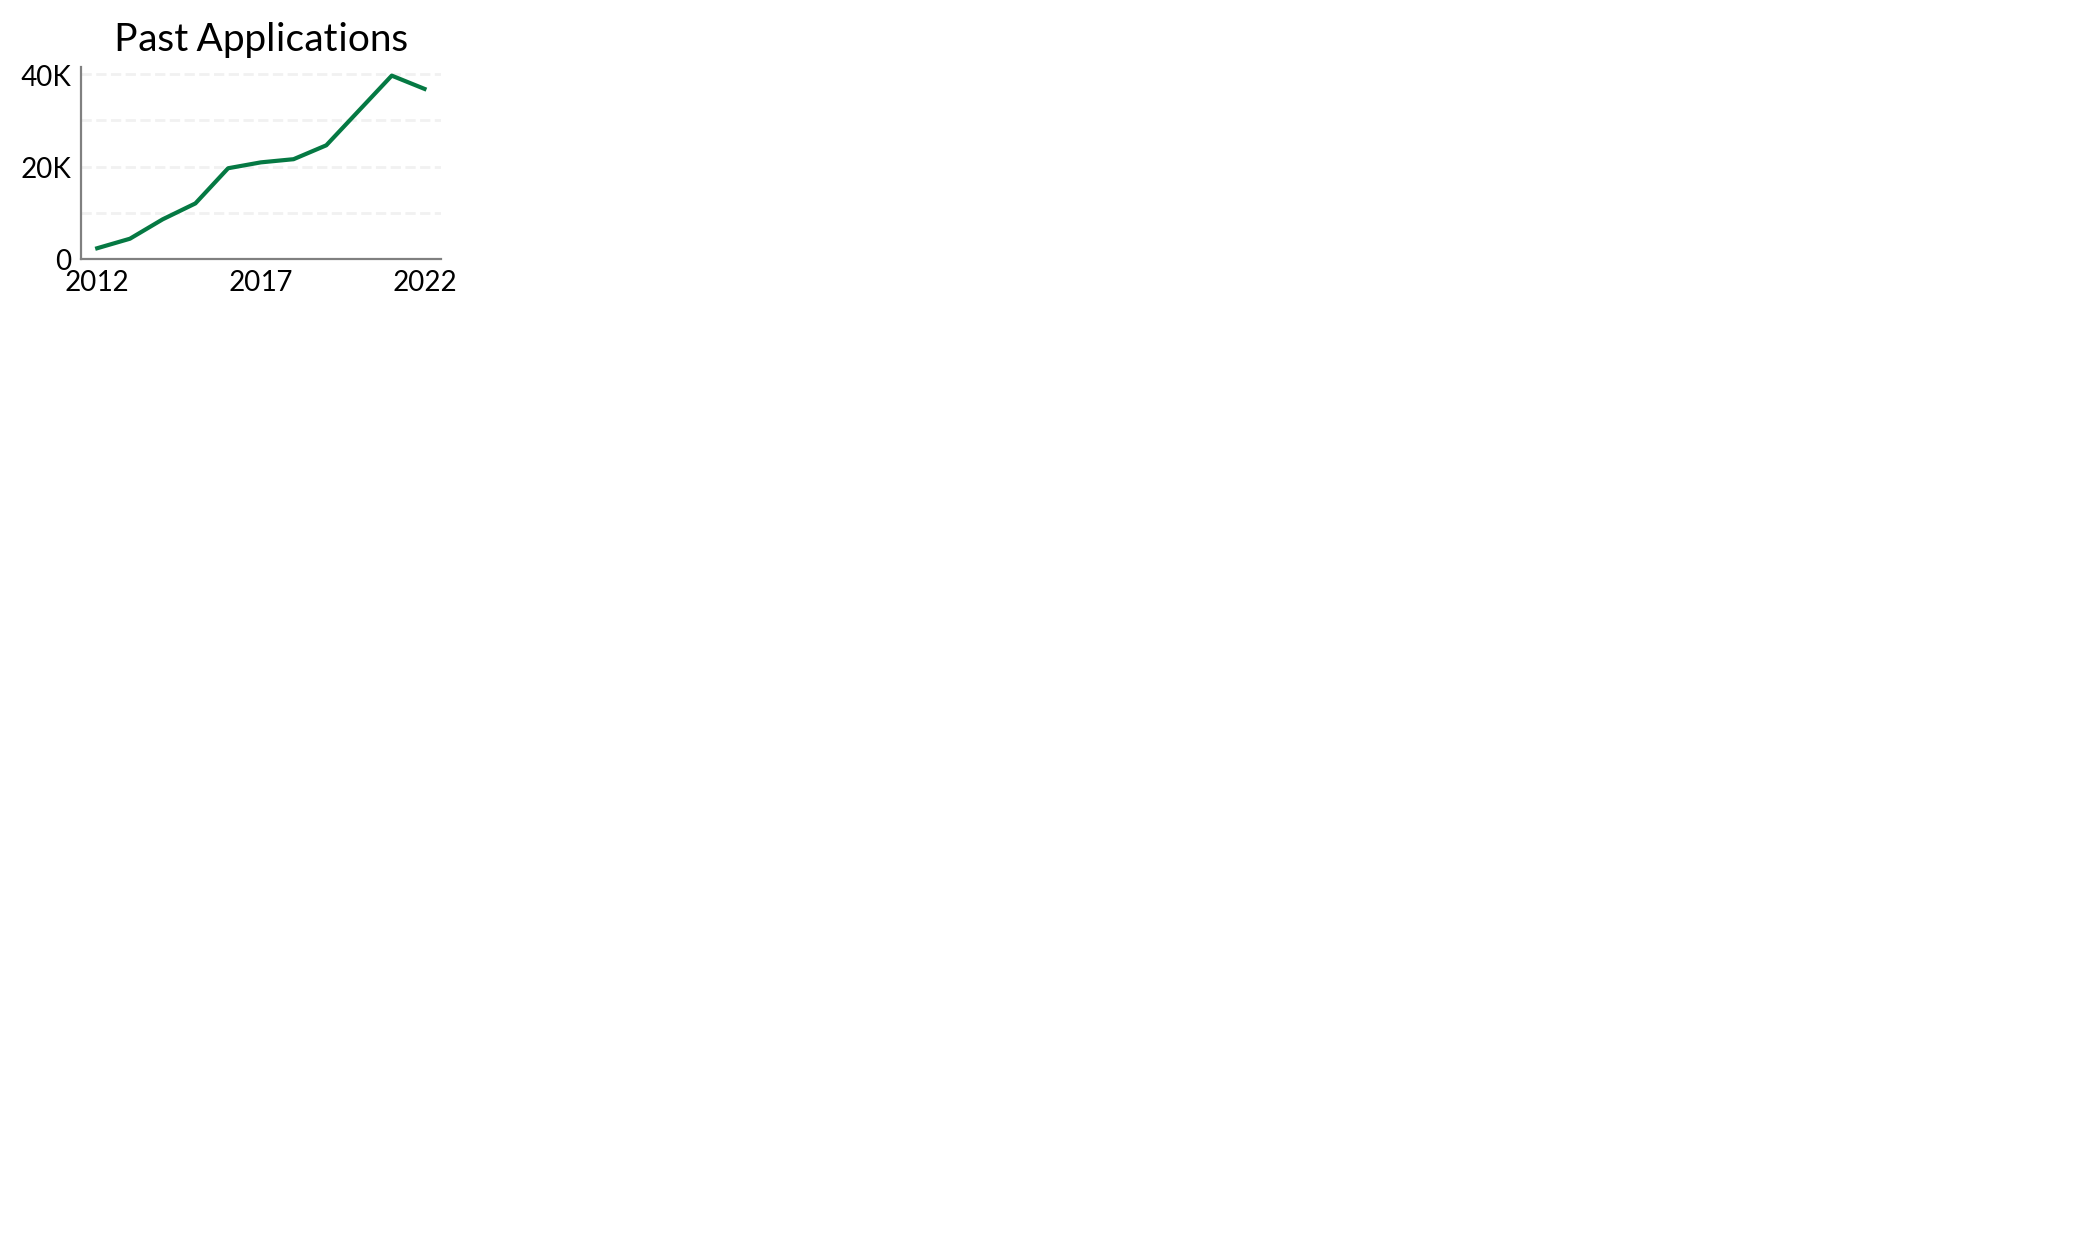

In [78]:
def draw_past_applications(ax):
    # Plot data
    ax.plot(df_hist["year"], df_hist["applications"], color=COLOR)
    # Handle axes and ticks
    ax.axis("on")
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    number_format_axis(ax.yaxis)
    ax.set_yticks([0, 20000, 40000])
    ax.set_yticks([0, 10000, 20000, 30000, 40000], minor=True)
    ax.set_xticks([2012, 2017, 2022])
    # Set title
    ax.set_title("Past Applications", size=TITLE_FS)


axes = create_axes()
draw_past_applications(axes[0])

<Figure size 432x288 with 0 Axes>

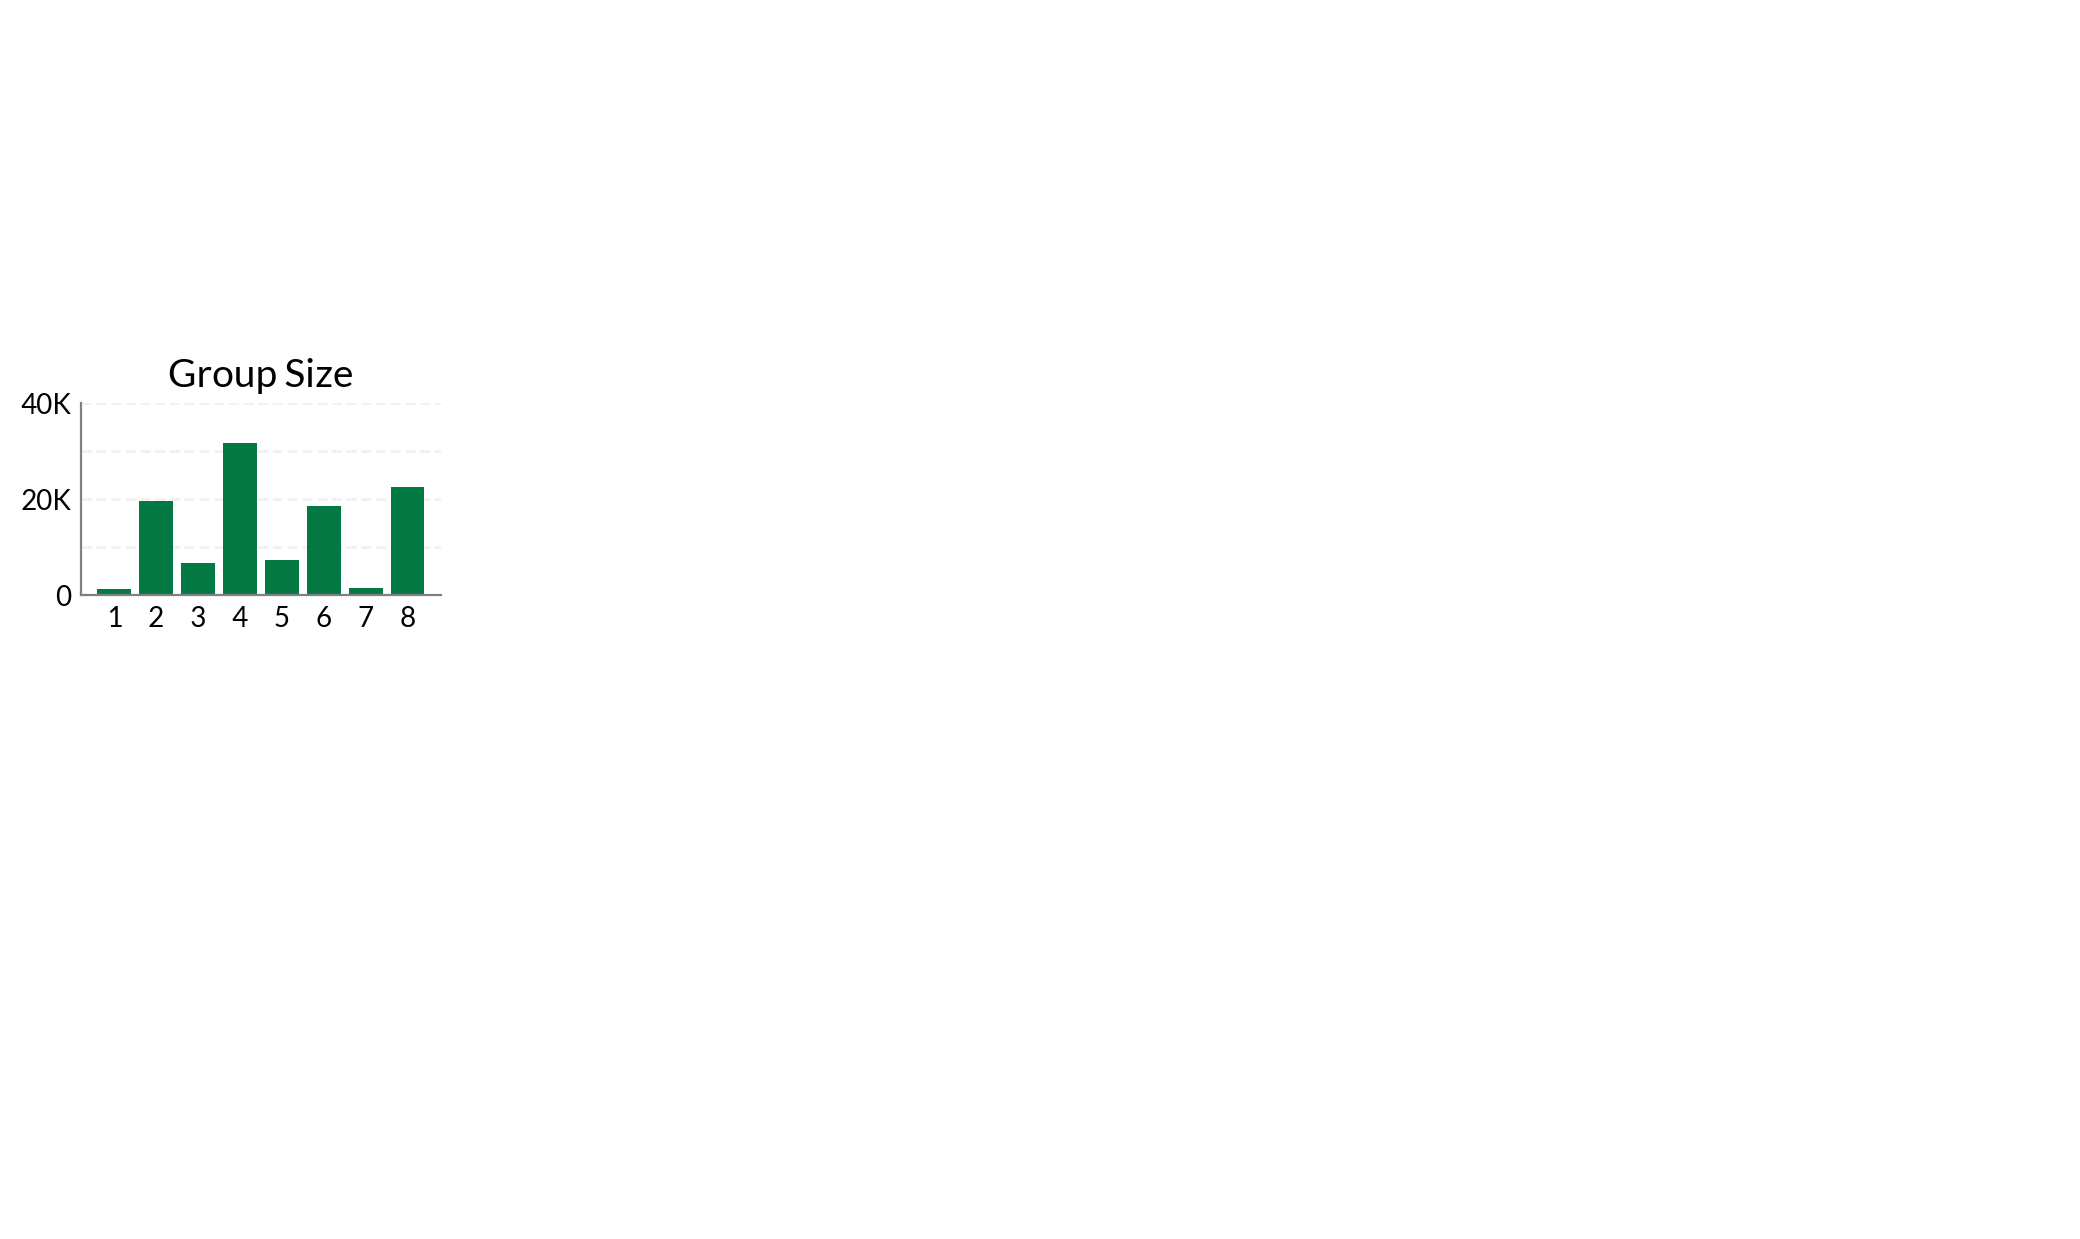

In [79]:
def draw_group_size(ax):
    # Generate data
    df_group = df.groupby("group_size").agg(count=("zone", "count")).reset_index()
    # Plot data
    ax.bar(df_group["group_size"], df_group["count"], color=COLOR)
    # Handle axes and ticks
    ax.axis("on")
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    number_format_axis(ax.yaxis)
    ax.set_yticks([0, 20000, 40000])
    ax.set_yticks([0, 10000, 20000, 30000, 40000], minor=True)
    ax.set_xticks(range(1, 9))
    # Set title
    ax.set_title("Group Size", size=TITLE_FS)


axes = create_axes()
draw_group_size(axes[1])

<Figure size 432x288 with 0 Axes>

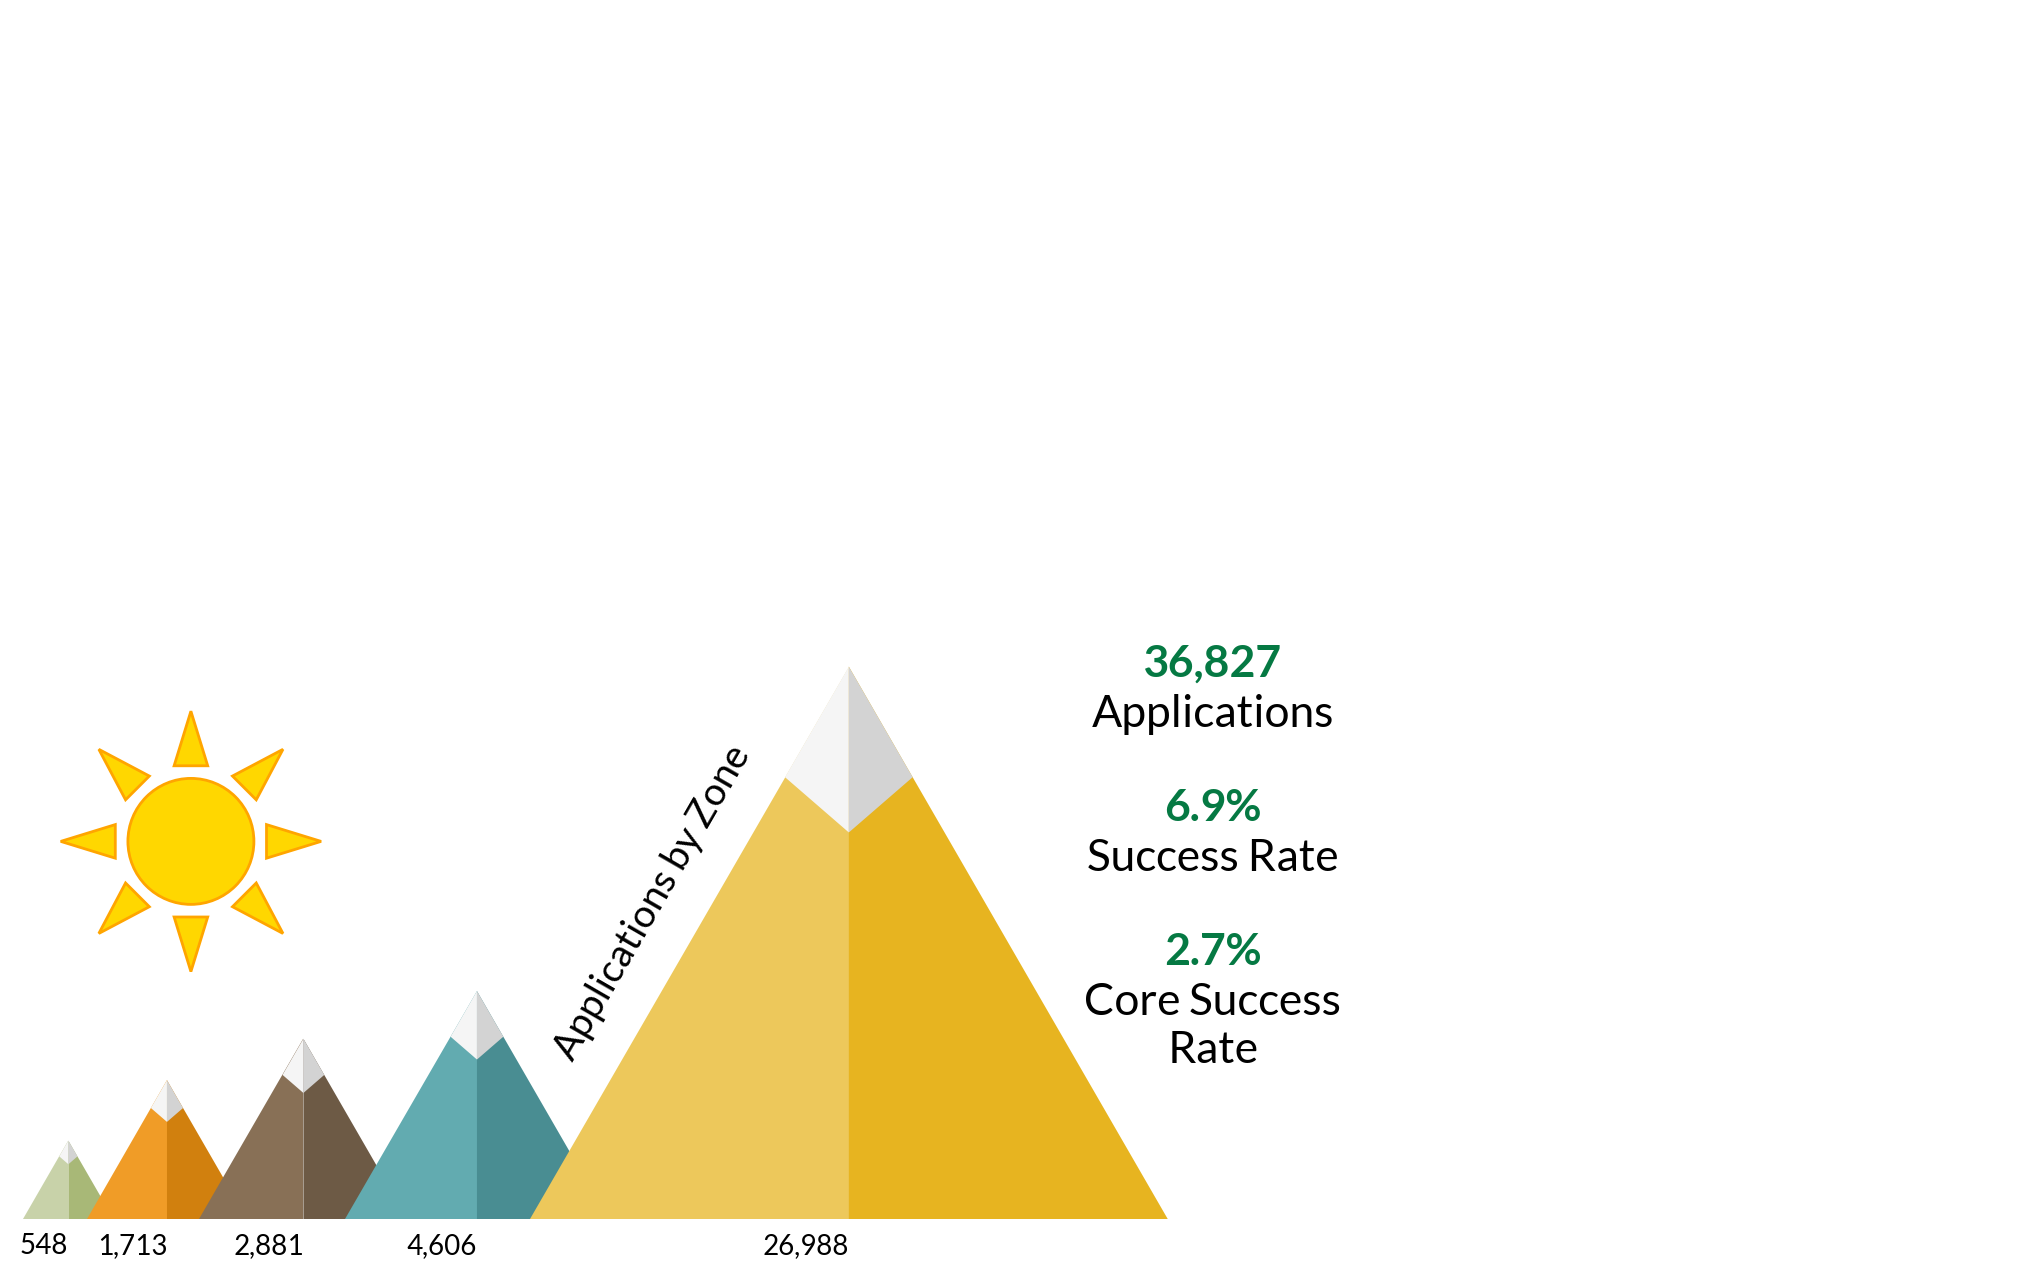

In [80]:
def draw_mountains(ax):
    # Plot data
    off = 0
    max_apps = df_zones["applications"].max()
    for i, row in df_zones.sort_values("applications").iterrows():
        if "stock" in row["zone"]:
            continue

        polys = []

        a = math.sqrt((row["applications"] / max_apps) * 4 / math.sqrt(3))
        h = 0.5 * math.sqrt(3) * a
        polys.append(
            (
                [[off, 0], [off + a / 2, 0], [off + a / 2, h]],
                ZONE_COLORS[row["zone"]],
            )
        )
        polys.append(
            (
                [[off + a / 2, 0], [off + a, 0], [off + a / 2, h]],
                scale_lightness(ZONE_COLORS[row["zone"]], 0.8),
            )
        )

        snow_h = 0.3 * h
        snow_x = 2 * snow_h / 3 / math.sqrt(3)
        polys.append(
            (
                [
                    [off + a / 2 - snow_x, h - snow_h * 2 / 3],
                    [off + a / 2, h - snow_h],
                    [off + a / 2, h],
                ],
                "whitesmoke",
            )
        )
        polys.append(
            (
                [
                    [off + a / 2 + snow_x, h - snow_h * 2 / 3],
                    [off + a / 2, h - snow_h],
                    [off + a / 2, h],
                ],
                "lightgray",
            )
        )

        for points, color in polys:
            ax.add_patch(Polygon(points, color=color, ec=None))

        ax.text(off + a / 2, -0.08, f'{row["applications"]:,}', fontsize=10, ha="right")

        off = off + (a / 2) * 1.4

    # Add the sun
    xy = (0.4, 0.9)
    r = 0.15
    ax.add_patch(Circle(xy, r, color=SUN_COLOR, ec=SUN_EDGE_COLOR))
    triangle = [(0.71, xy[1]), (0.58, xy[1] + 0.04), (0.58, xy[1] - 0.04)]
    for i in range(0, 8):
        angle = math.pi * i / 4
        ax.add_patch(
            Polygon(
                [rotate(xy, p, angle) for p in triangle],
                color=SUN_COLOR,
                ec=SUN_EDGE_COLOR,
            )
        )

    # Set the range for the plot
    mountain_w = off + a / 2
    xlim = mountain_w * 1.1
    ax.set_xlim([0, xlim])
    ylim = mountain_w * 1.1 * H / W * 0.6 / 0.7
    ax.set_ylim([0, ylim])

    # Set title
    ax.set_title("Applications by Zone", y=0.2, x=0.45, rotation=60, size=TITLE_FS)

    # Add summary text
    apps = df_zones["applications"].sum()
    awarded = sum(df["result"] == "Awarded")
    core_apps = df_zones.loc[
        df_zones["zone"] == "Core Enchantment Zone", "applications"
    ].item()
    core_awarded = sum(
        df.loc[df["zone"] == "Core Enchantment Zone"]["result"] == "Awarded"
    )

    # Scorecards to the right
    off = 0.8
    scorecards = [
        (f"{apps:,}", "Applications"),
        (f"{awarded/apps:.1%}", "Success Rate"),
        (f"{core_awarded/core_apps:.1%}", "Core Success\nRate"),
    ]
    for (value, label) in scorecards:
        ax.text(
            xlim * 0.85,
            ylim * off,
            value,
            size=16,
            weight="bold",
            ha="center",
            va="top",
            color=COLOR,
        )
        ax.text(xlim * 0.85, ylim * (off - 0.07), label, size=16, ha="center", va="top")
        off -= 0.2


axes = create_axes()
draw_mountains(axes[2])

<Figure size 432x288 with 0 Axes>

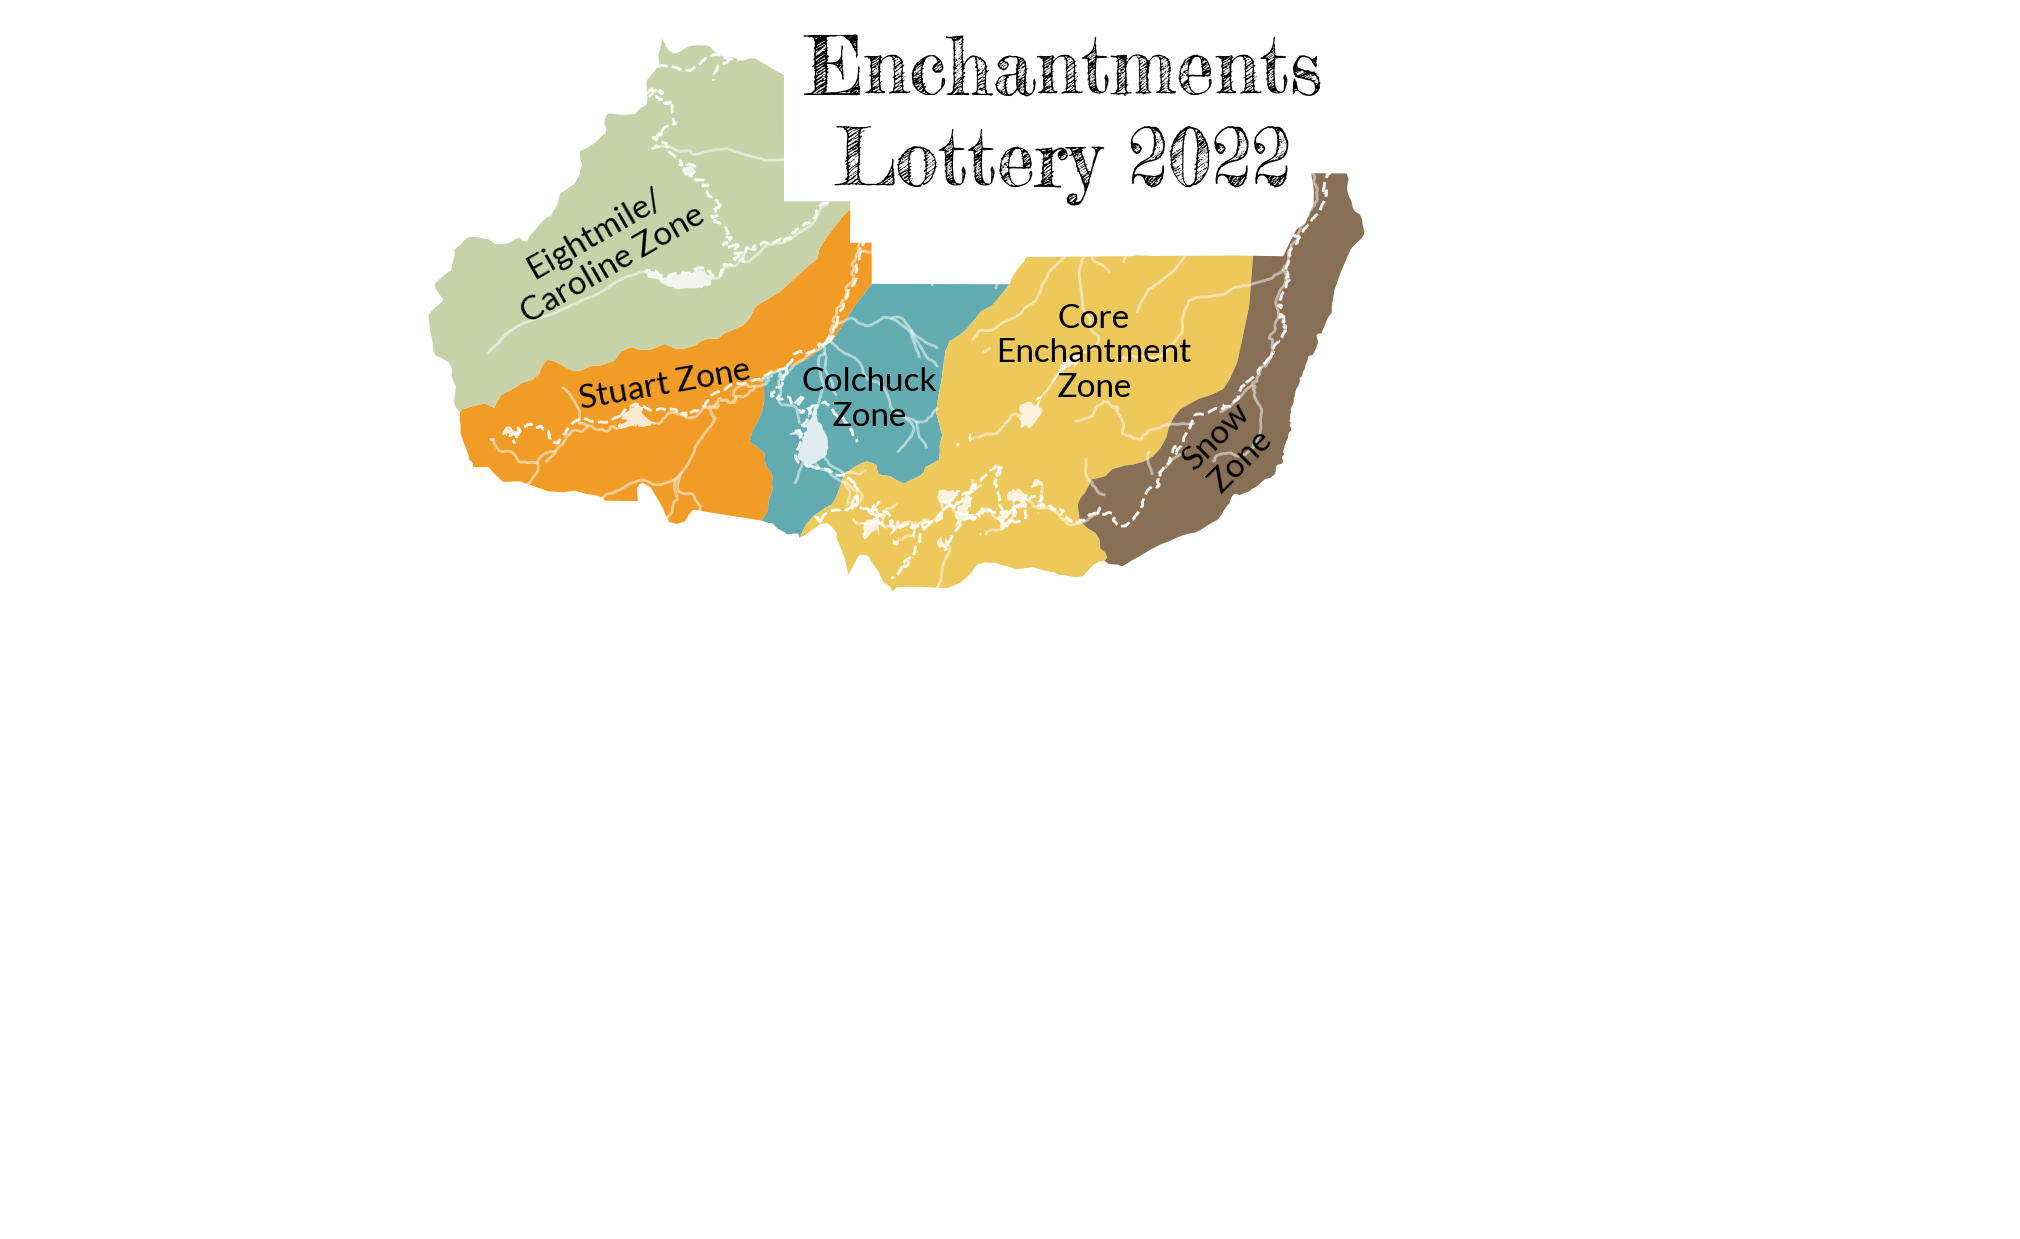

In [81]:
def draw_map(ax):
    # Plot data
    ax = df_places.plot(fc=df_places["color"], ax=ax)
    ax = df_rivers.plot(color="white", linewidth=1, alpha=0.5, ax=ax)
    ax = df_trails.plot(
        color="white", linestyle="dashed", alpha=0.9, linewidth=1, ax=ax
    )
    ax = df_lakes.plot(color="white", alpha=0.8, ax=ax)

    # Set domain and range
    ax.set_xlim([-120.93, -120.695])
    ax.set_ylim([47.462, 47.565])
    ax.set_aspect(1.4)

    # Add labels
    fs = 12
    ax.text(
        -120.885,
        47.513,
        "Eightmile/\nCaroline Zone",
        fontsize=fs,
        ha="center",
        rotation=30,
    )
    ax.text(-120.87, 47.498, "Stuart Zone", fontsize=fs, ha="center", rotation=10)
    ax.text(-120.82, 47.495, "Colchuck\nZone", fontsize=fs, ha="center")
    ax.text(-120.765, 47.5, "Core\nEnchantment\nZone", fontsize=fs, ha="center")
    ax.text(-120.732, 47.483, "Snow\nZone", fontsize=fs, ha="center", rotation=45)

    # Add title
    ax.set_title(
        "Enchantments\nLottery 2022",
        x=0.67,
        y=0.7,
        fontproperties=TITLE_FONT,
        fontsize=28,
    )


axes = create_axes()
draw_map(axes[3])

<Figure size 432x288 with 0 Axes>

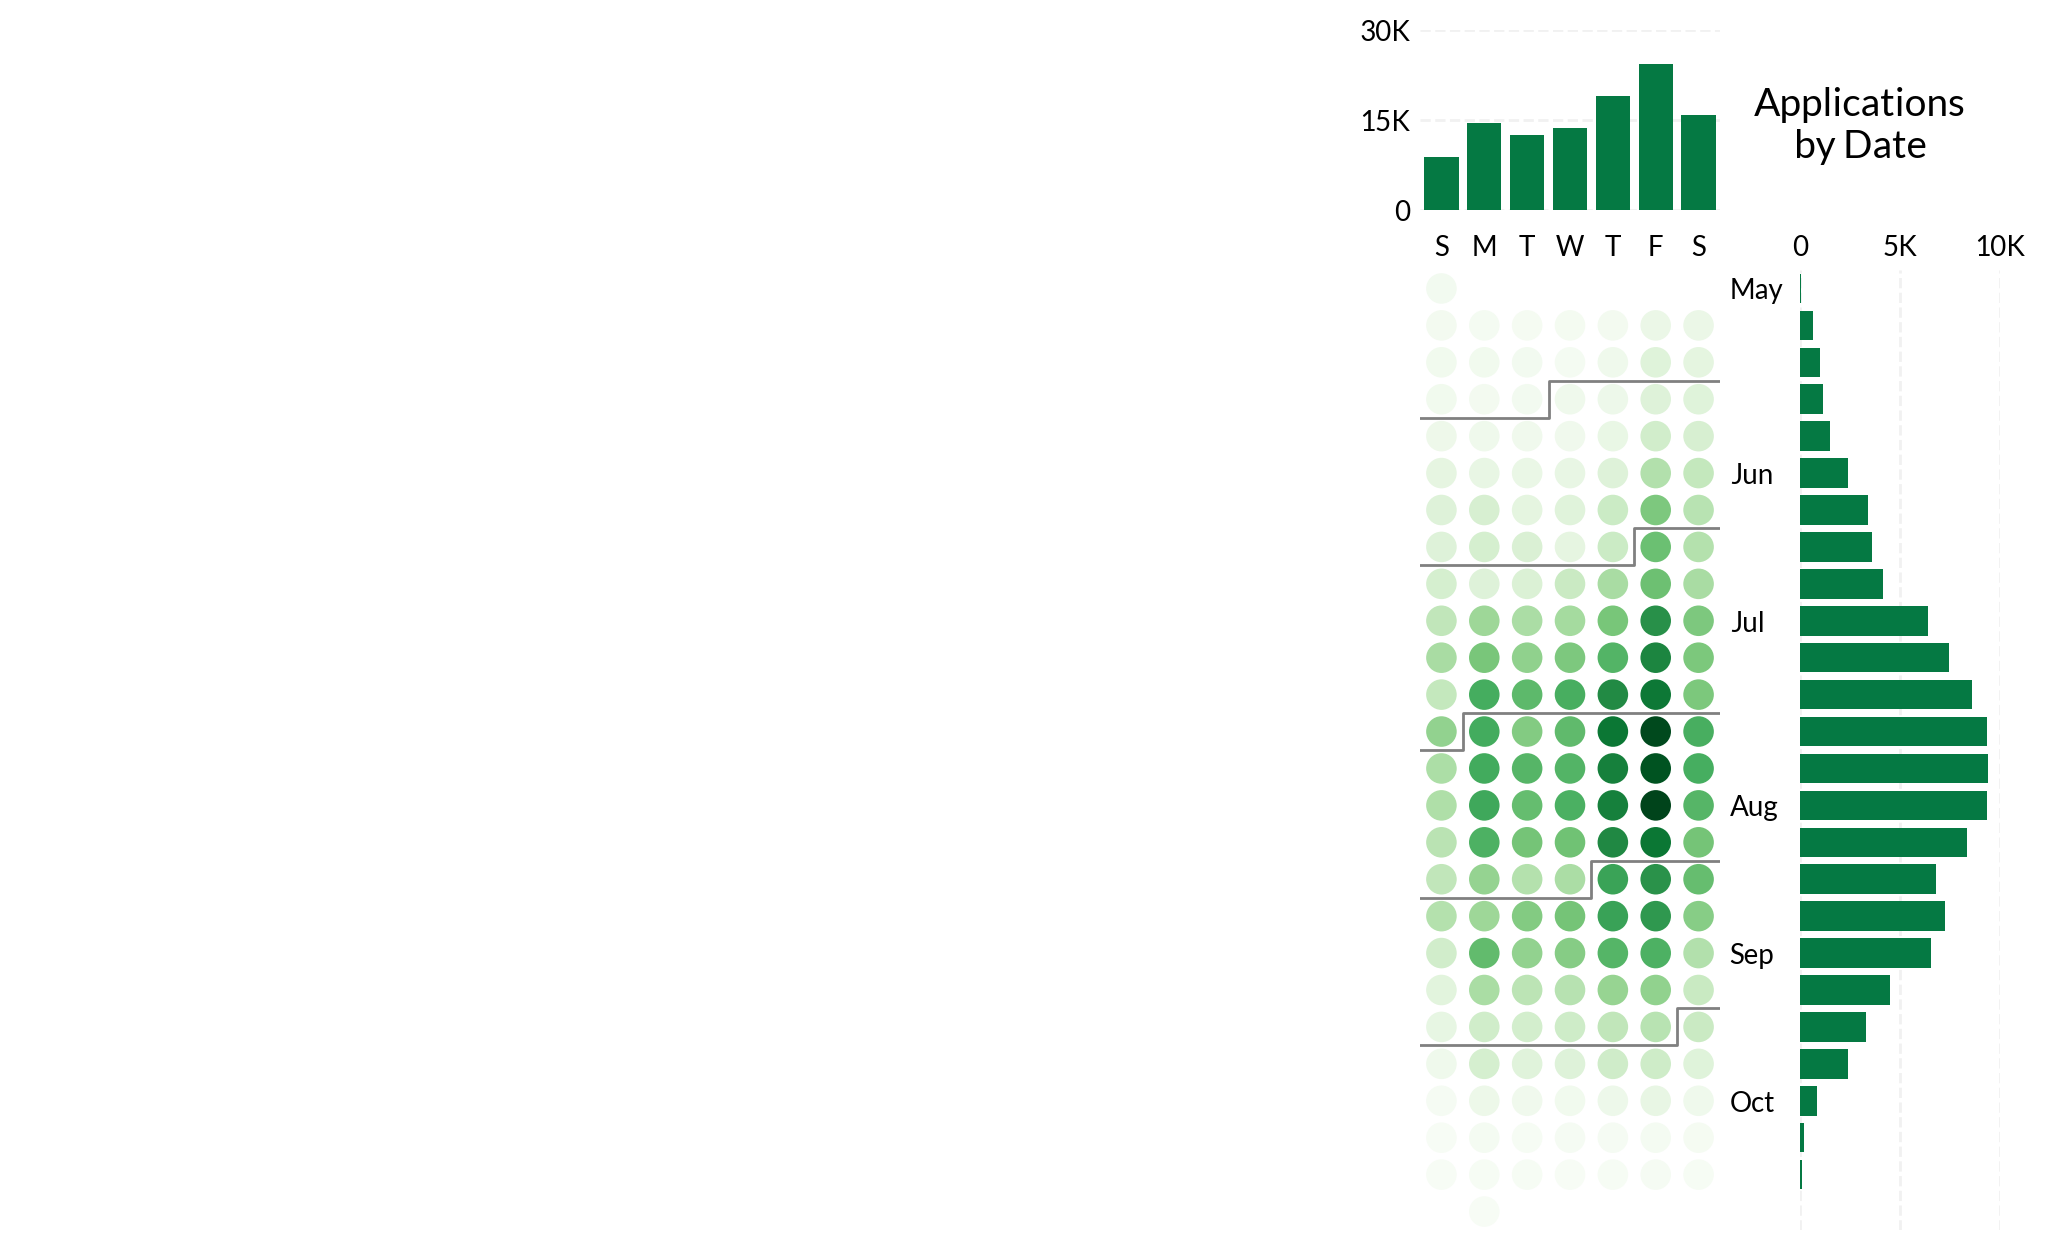

In [82]:
def draw_heatmap(ax4, ax5, ax6):
    # Generate data

    # Grouped data for heatmap
    df_group = (
        df.groupby(["day_of_week", "week_of_year"])
        .agg({"entry_date": "count"})
        .reset_index()
        .rename(columns={"entry_date": "count"})
    )
    # Calculate lines between months
    months = (
        df[df["day_of_month"] == 1]
        .drop_duplicates(subset=["entry_date", "week_of_year"])
        .sort_values("week_of_year")
    )
    lines = []
    for i, row in months.iterrows():
        week = row["week_of_year"]
        x = [-0.5, row["day_of_week"] - 0.5, row["day_of_week"] - 0.5, 6.5]
        y = [week + 0.5, week + 0.5, week - 0.5, week - 0.5]
        lines.append((x, y))
    # Calculate month labels
    month_labels = (
        df[df["day_of_month"] == 15]
        .drop_duplicates(subset=["entry_date", "week_of_year"])
        .sort_values("week_of_year")
    )
    month_labels["month"] = month_labels["entry_date"].dt.month_name().str[:3]

    # Plot data

    # Heatmap
    ax4.scatter(
        df_group["day_of_week"],
        df_group["week_of_year"],
        marker="o",
        s=100,
        c=df_group["count"],
        cmap=COLORMAP,
    )
    # Draw borders between months
    for (x, y) in lines:
        ax4.plot(x, y, color=EDGE_COLOR, linewidth=1)

    # Axis labels
    ax4.axis("on")
    ax4.set_xticks(range(0, 7))
    ax4.set_xticklabels(["S", "M", "T", "W", "T", "F", "S"])
    ax4.invert_yaxis()
    ax4.set_yticks(list(month_labels["week_of_year"]))
    ax4.set_yticklabels(list(month_labels["month"]))
    ylim = [df_group["week_of_year"].max() + 0.5, df_group["week_of_year"].min() - 0.5]
    ax4.set_ylim(ylim)
    xlim = [-0.5, 6.5]
    ax4.set_xlim(xlim)
    ax4.tick_params(labeltop=True, labelbottom=False, labelright=True, labelleft=False)
    ax4.grid(False)

    # Day of week chart
    df_day_of_week = df_group.groupby("day_of_week").agg({"count": "sum"}).reset_index()
    ax5.bar(df_day_of_week["day_of_week"], df_day_of_week["count"], width=0.8, color=COLOR)
    ax5.set_xlim(xlim)
    ax5.axis("on")
    ax5.set_yticks([0, 15000, 30000])
    number_format_axis(ax5.yaxis)

    # Week of year chart
    df_week_of_year = df_group.groupby("week_of_year").agg({"count": "sum"}).reset_index()
    ax6.barh(df_week_of_year["week_of_year"], df_week_of_year["count"], height=0.8, color=COLOR)
    ax6.set_ylim(ylim)
    ax6.axis("on")
    ax6.set_xticks([0, 5000, 10000])
    number_format_axis(ax6.xaxis)
    ax6.grid(which="both", axis="x", ls="--", color=GRID_COLOR, linewidth=1)
    ax6.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

    # Add title
    ax6.set_title("Applications\nby Date", x=0.3, y=1.1, size=TITLE_FS)


axes = create_axes()
draw_heatmap(axes[4], axes[5], axes[6])

<Figure size 432x288 with 0 Axes>

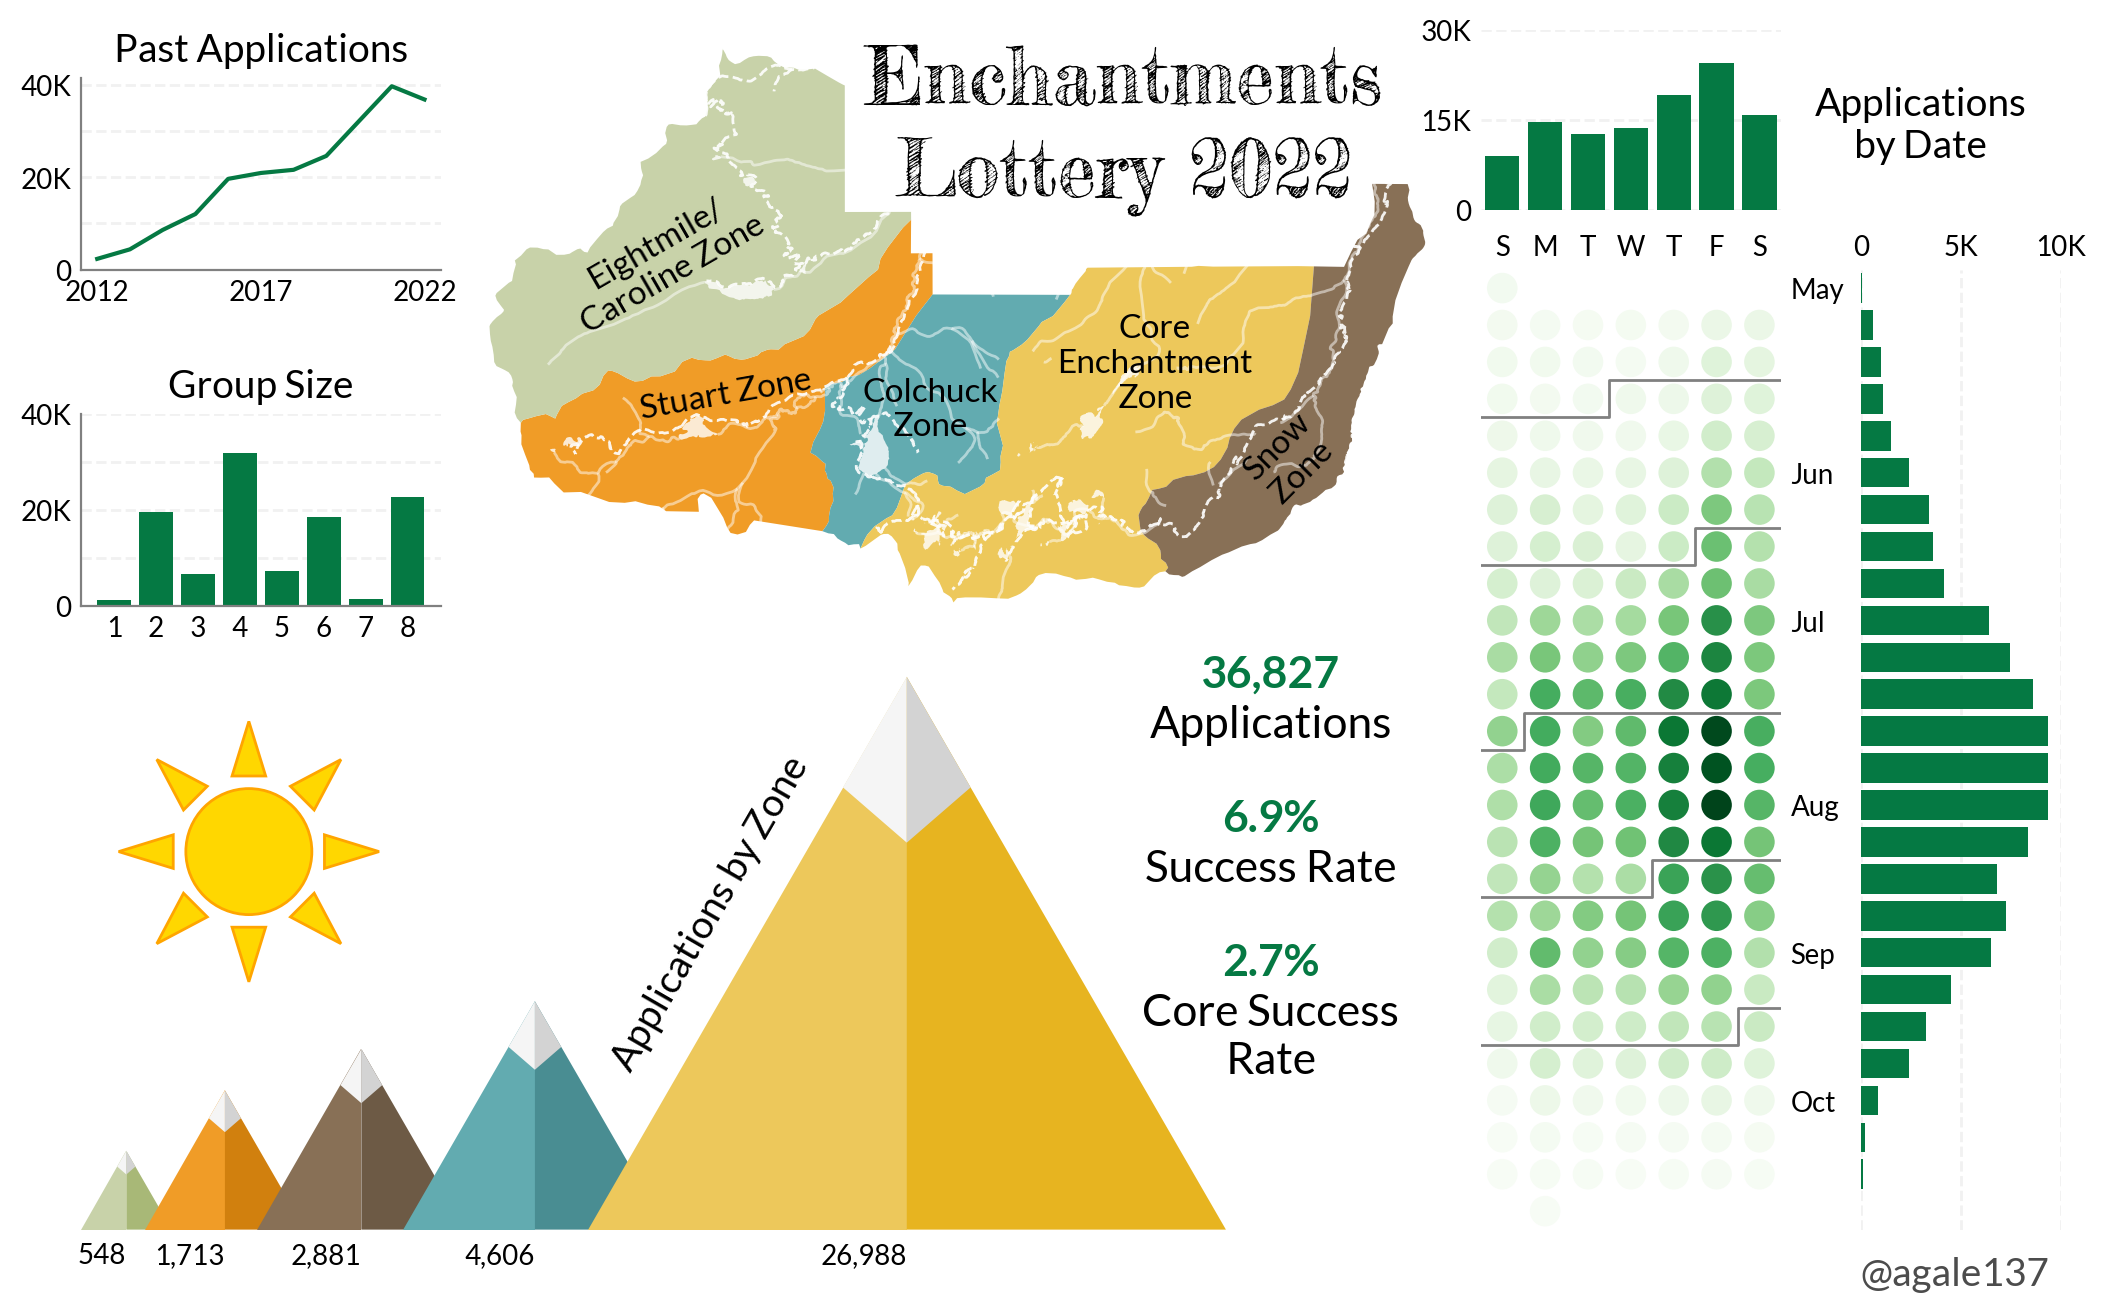

In [83]:
# Put everything together
axes = create_axes()

draw_past_applications(axes[0])
draw_group_size(axes[1])
draw_mountains(axes[2])
draw_map(axes[3])
draw_heatmap(axes[4], axes[5], axes[6])

# Add username
plt.text(1, 46, "@agale137", fontsize=TITLE_FS, alpha=0.7)

plt.savefig("images/final_2.png", bbox_inches="tight", transparent=False, pad_inches=0.5)